## Import Libraries

In [181]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [182]:
df = pd.read_csv("Data/Coursera.csv")

In [183]:
df.shape

(3404, 9)

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3404 entries, 0 to 3403
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Subject           3404 non-null   object 
 1   Title             3404 non-null   object 
 2   Institution       3404 non-null   object 
 3   Learning Product  3404 non-null   object 
 4   Level             3404 non-null   object 
 5   Duration          3404 non-null   object 
 6   Gained Skills     3404 non-null   object 
 7   Rate              3404 non-null   float64
 8   Reviews           3404 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 239.5+ KB


## Machine Learning (DBSCAN)

___________________________________________________________________________________________________________

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


In [186]:
df = pd.read_csv("Data/Coursera.csv")

In [187]:
# Select the best feature combination
X = df[['Level', 'Reviews', 'Rate']]

In [188]:
# Define which features are numeric and which are categorical
numeric_features = ['Rate', 'Reviews']
categorical_features = ['Level']

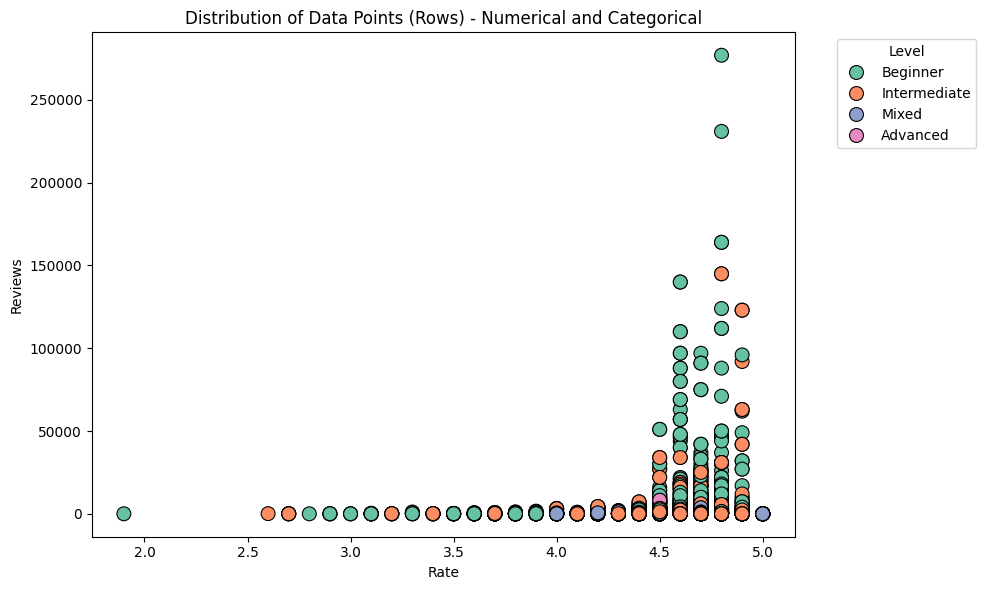

In [222]:
# Plot numerical features (PCA components)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rate', y='Reviews', data=X, hue=categorical_features[0], palette='Set2', s=100, edgecolor='black')

# Customize the plot
plt.title('Distribution of Data Points (Rows) - Numerical and Categorical')
plt.xlabel('Rate')
plt.ylabel('Reviews')
plt.legend(title=categorical_features[0], bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot

plt.tight_layout()
plt.show()


In [190]:
# Build a preprocessing pipeline: scale numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [191]:
# Apply preprocessing
X_processed = pipeline.fit_transform(X)

In [192]:
# --- Step 1: Calculate the k-distance graph ---
min_samples = 5  # Minimum number of points to form a dense region
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_processed)
distances, indices = nn.kneighbors(X_processed)

In [193]:
# The distance to the min_samples-th nearest neighbor for each point
k_dist = distances[:, min_samples-1]

In [194]:
# Sort distances
k_dist_sorted = np.sort(k_dist)

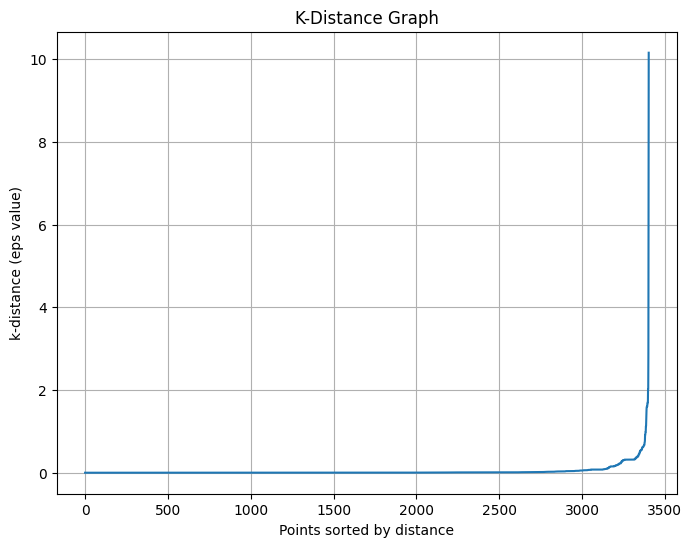

In [195]:
# Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [196]:
# --- Step 2: Choose eps from the k-distance graph ---
# After visually inspecting the k-distance graph, choose an appropriate eps value, e.g., at the "elbow"
chosen_eps = 0.5  # Example chosen value, update based on the k-distance graph

In [197]:
# --- Step 3: Apply DBSCAN with chosen eps ---
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples, metric='euclidean')
final_labels = dbscan.fit_predict(X_processed)

In [223]:
# Add the cluster labels to the DataFrame
X['Cluster_DBSCAN'] = final_labels

In [224]:
# --- Step 4: Evaluate the clustering with Silhouette Score ---
# Calculate the silhouette score for the final clustering (only if there are at least 2 clusters)
unique_labels = np.unique(final_labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

if num_clusters >= 2:
    silhouette_avg = silhouette_score(X_processed, final_labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Silhouette score cannot be computed as there are fewer than 2 clusters.")


Silhouette Score: 0.42671707212466076


In [225]:
# Display final clustering results for DBSCAN
print("DBSCAN Cluster Distribution:")
print(X['Cluster_DBSCAN'].value_counts())

DBSCAN Cluster Distribution:
Cluster_DBSCAN
 0    1706
 1    1128
 2     369
 3     143
-1      34
 4       8
 5       6
 7       5
 6       5
Name: count, dtype: int64


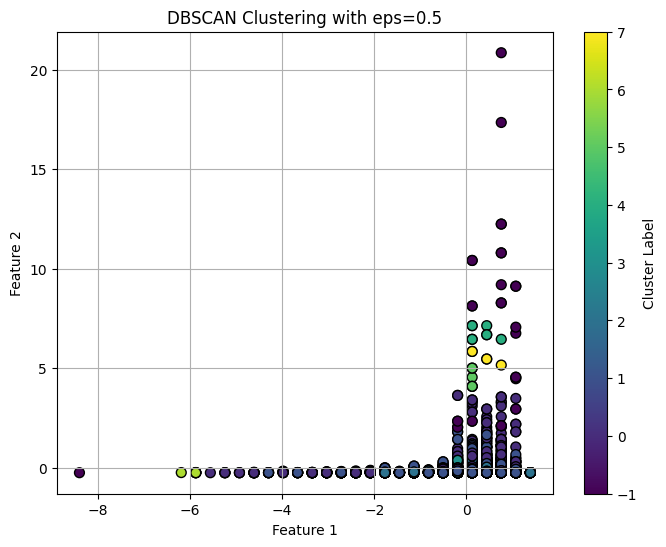

In [201]:
# Optional: Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_processed[:, 0], X_processed[:, 1], c=final_labels, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [226]:
df_filtered = X[X['Cluster_DBSCAN'].isin([0, 1, 2, 3])]


num_clusters_filtered = len(df_filtered['Cluster_DBSCAN'].unique())
print("Number of clusters (filtered):", num_clusters_filtered)


if num_clusters_filtered >= 2:
    X_filtered = pipeline.transform(df_filtered[['Level', 'Reviews', 'Rate']])
    score = silhouette_score(X_filtered, df_filtered['Cluster_DBSCAN'])
    print("Silhouette Score (filtered):", score)
else:
    print("Not enough clusters to compute Silhouette Score.")


Number of clusters (filtered): 4
Silhouette Score (filtered): 0.4477928076803547



Cluster counts (filtered):
 Cluster_DBSCAN
0    1706
1    1128
2     369
3     143
Name: count, dtype: int64


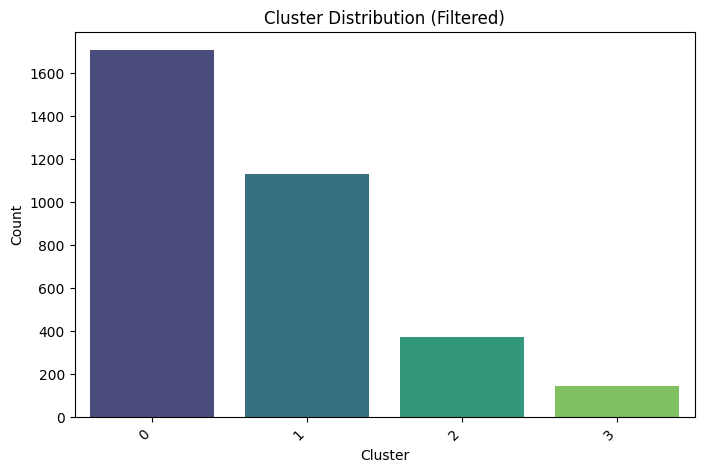

In [228]:
# Print the value count for each cluster
cluster_counts = df_filtered['Cluster_DBSCAN'].value_counts()
print("\nCluster counts (filtered):\n", cluster_counts)

# Visualize the cluster distribution with a countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x='Cluster_DBSCAN', palette='viridis')
plt.title('Cluster Distribution (Filtered)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [229]:
import os

output_dir = "clusters"
os.makedirs(output_dir, exist_ok=True)


# Save each valid cluster in a separate CSV file
for cluster_num in sorted(df_filtered['Cluster_DBSCAN'].unique()):
    cluster_df = df_filtered[df_filtered['Cluster_DBSCAN'] == cluster_num]

    # Define the file path for the current cluster CSV
    file_name = os.path.join(output_dir, f"Cluster{cluster_num}.csv")

    # Save the cluster DataFrame to a CSV file
    cluster_df.to_csv(file_name, index=False)

    # Print confirmation message
    print(f"Cluster {cluster_num} saved as {file_name}. Size: {len(cluster_df)} records.")


Cluster 0 saved as clusters/Cluster0.csv. Size: 1706 records.
Cluster 1 saved as clusters/Cluster1.csv. Size: 1128 records.
Cluster 2 saved as clusters/Cluster2.csv. Size: 369 records.
Cluster 3 saved as clusters/Cluster3.csv. Size: 143 records.


In [230]:
import pandas as pd

X['Cluster_DBSCAN'] = X['Cluster_DBSCAN'].replace({0: 'Solid Foundations & Practical Skills', 1: 'Trusted & Widely Recognized Courses', 2: 'Elite & High-Impact Learning', 3: 'Emerging & Experimental Learning Paths'})


In [231]:
X

,Level,Reviews,Rate,Cluster_DBSCAN
0,Beginner,6100,4.4,Solid Foundations & Practical Skills
1,Intermediate,11000,4.6,Trusted & Widely Recognized Courses
2,Beginner,30000,4.8,Solid Foundations & Practical Skills
3,Intermediate,1800,4.4,Trusted & Widely Recognized Courses
4,Mixed,4800,4.8,Elite & High-Impact Learning
...,...,...,...,...
3399,Intermediate,14,4.6,Trusted & Widely Recognized Courses
3400,Intermediate,46,4.3,Trusted & Widely Recognized Courses
3401,Intermediate,66,4.6,Trusted & Widely Recognized Courses
3402,Intermediate,12,4.1,Trusted & Widely Recognized Courses


In [232]:
import joblib
joblib.dump(DBSCAN, "DBSCAN_model.pkl")
print("DBSCAN model saved!")

DBSCAN model saved!
